# Web ML System

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

from functions_ml import *

## Preprocessing data for binary classification (Web or Benign)

In [2]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

file_path = '.\Files\\Web\\'

135 34


### Scaling

In [4]:
try:
    scaler = joblib.load('.\\Web_model\\scaler.joblib')
except:
    scaler = MinMaxScaler()

    for train_set in tqdm(train_sets):
        scaler.fit(read_csv_file(train_set)[X_columns])

    joblib.dump(scaler, '.\\Web_model\\scaler.joblib')

100%|██████████| 135/135 [01:34<00:00,  1.42it/s]


### Dictionnary for spliting data

In [5]:
dict_3_classes = {}
dict_3_classes['BrowserHijacking'] = 'Web'
dict_3_classes['Backdoor_Malware'] = 'Web'
dict_3_classes['XSS'] = 'Web'
dict_3_classes['Uploading_Attack'] = 'Web'
dict_3_classes['SqlInjection'] = 'Web'
dict_3_classes['CommandInjection'] = 'Web'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['DDoS-RSTFINFlood'] = 'Other'
dict_3_classes['DDoS-PSHACK_Flood'] = 'Other'
dict_3_classes['DDoS-SYN_Flood'] = 'Other'
dict_3_classes['DDoS-UDP_Flood'] = 'Other'
dict_3_classes['DDoS-TCP_Flood'] = 'Other'
dict_3_classes['DDoS-ICMP_Flood'] = 'Other'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'Other'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'Other'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'Other'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'Other'
dict_3_classes['DDoS-SlowLoris'] = 'Other'
dict_3_classes['DDoS-HTTP_Flood'] = 'Other'
dict_3_classes['DoS-UDP_Flood'] = 'Other'
dict_3_classes['DoS-SYN_Flood'] = 'Other'
dict_3_classes['DoS-TCP_Flood'] = 'Other'
dict_3_classes['DoS-HTTP_Flood'] = 'Other'
dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

### Refactoring data

In [6]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [02:29<00:00,  1.12it/s]


### Counting number of samples per class

4


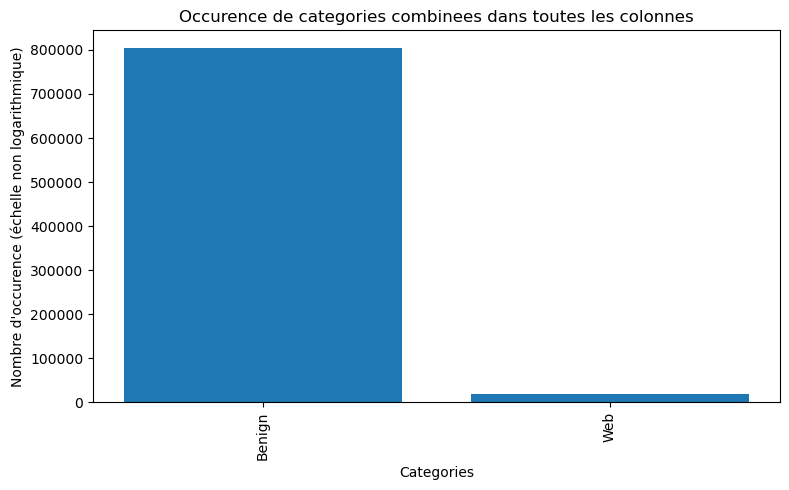

In [7]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurence de categories combinees dans toutes les colonnes', 'Categories', 'Nombre d\'occurence', 8, 5, log_scale=False)

## Define variables

In [8]:
performance_path = 'performance.csv'
file_path = '.\Files\\Web\\'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
print(len(X_columns))
X_columns = X_columns[:-1]
y_column = 'label'
z_column = 'Binary'

4
47


## First model (Binary (Web or Benigh))

### Building model

In [9]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
]

In [10]:
model_path = '.\\Web_model\\Binary\\'
file_path = '.\Files\\Web\\'

try:
    # Load the encoder from a file
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    # scaler = MinMaxScaler()
    encoder = LabelEncoder()

try:
    # Load performance dataframe
    performance = read_csv_file(performance_path, model_path)
except:
    # Define performance dataframe
    performance = pd.DataFrame(columns=['Model', 'Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL', 'Total rows'])

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path, X_columns=X_columns , y_column=z_column, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path+'encoder.joblib')

100%|██████████| 3/3 [02:39<00:00, 53.26s/it]


['.\\Web_model\\Binary\\encoder.joblib']

#### Hyperparameters tuning

In [15]:
param_space_decision_tree = {
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

param_space_random_forest = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 1.0),
}

param_space_xgboost = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'learning_rate': (0.01, 1.0),
}

simpleModelsDef[0]['param_space'] = param_space_decision_tree
simpleModelsDef[1]['param_space'] = param_space_random_forest
simpleModelsDef[2]['param_space'] = param_space_xgboost

In [16]:
model_path = '.\\Recon_model\\Binary\\'
performance_path = 'tuning_performance.csv'

try:
    # Load the encoder from a file
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    # scaler = MinMaxScaler()
    encoder = LabelEncoder()

# Hyperparameters tuning models
for model in tqdm(simpleModelsDef):
    optimize_hyperparameters(model['Model'], model['Name'], file_path, model_path, model['param_space'], train_sets, X_columns, y_column=z_column, encoder=encoder, scaler=scaler, n_splits=5, n_iter=10)


# try:
#     # Load performance dataframe
#     performance = read_csv_file(performance_path, model_path)
# except:
#     # Define performance dataframe
#     performance = pd.DataFrame(columns=['Model', 'Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL', 'Total rows'])

# # Buidling models
# for model in tqdm(simpleModelsDef):
#     # Build model
#     performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path, X_columns=X_columns , y_column=z_column, encoder=encoder, scaler=scaler, confusionMatrix=False)

#     # Save performance
#     performance.to_csv(model_path + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path+'encoder.joblib')

100%|██████████| 3/3 [3:02:20<00:00, 3646.70s/it]  


['.\\Recon_model\\Binary\\encoder.joblib']

#### Display performance

In [ ]:
# Preprocessing if necessary
model_path = '.\\Web_model\\Binary\\'
performance = read_csv_file(performance_path, model_path)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path + performance_path, index=False)

In [11]:
model_path = '.\\Web_model\\Binary\\'
read_csv_file(performance_path, model_path).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,0.997142,0.939562,0.993775,0.965022,0.993465,0.879450,0.964835,0.917623,0.001178,0.005358,364,1656,309091
1,RF,1.000000,1.000000,1.000000,1.000000,0.992219,0.832383,0.986275,0.894238,0.000301,0.007480,93,2312,309091
0,DT,1.000000,1.000000,1.000000,1.000000,0.988783,0.870403,0.872141,0.871270,0.005555,0.005662,1717,1750,309091


## Do prediction for after build sets

In [12]:
# Define model
model_path = '.\\Web_model\\Binary\\'
model = joblib.load(model_path + 'model_XGB.joblib')

try:
    # scaler = joblib.load(model_path+'scaler.joblib')
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[z_column] = encoder.inverse_transform(y_test)
new_after_build_set_scaled['Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set_scaled[y_column] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[z_column] != new_after_build_set_scaled['Prediction']])

new_after_build_set_scaled.to_csv('.\\Web_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled) * 100,len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set_scaled

res.head()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.993652,0.993652,0.993407,0.993348,1908,0.634802,300566


## Second model (All Web classes)

### Building model

In [13]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
]

In [14]:
model_path = '.\\Web_model\\All_classes\\'
filter_name = 'Web'

In [15]:
try:
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    encoder = LabelEncoder()

try:
    # Load performance dataframe
    performance = read_csv_file(performance_path, model_path)
except:
    # Define performance dataframe
    performance = pd.DataFrame(columns=['Model', 'Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL', 'Total rows'])

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path, X_columns=X_columns , y_column=y_column, z_column=z_column, encoder=encoder, filter_bool=True, filter_name=filter_name, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path + performance_path, index=False)

joblib.dump(encoder, model_path+'encoder.joblib')

100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


['.\\Web_model\\All_classes\\encoder.joblib']

### Display performance

In [ ]:
# Preprocessing if necessary

performance = read_csv_file(performance_path, model_path)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path + performance_path, index=False)

In [16]:
read_csv_file(performance_path, model_path).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,0.999912,0.999932,0.999932,0.999932,0.756483,0.715970,0.746936,0.728137,0.124294,0.119224,858,823,6903
1,RF,1.000000,1.000000,1.000000,1.000000,0.740113,0.686288,0.745134,0.704355,0.126756,0.133131,875,919,6903
0,DT,1.000000,1.000000,1.000000,1.000000,0.714182,0.688415,0.682324,0.685156,0.142836,0.142981,986,987,6903


## Final Prediction

In [17]:
# Define model
model_path = '.\\Web_model\\All_classes\\'
model = joblib.load(model_path + 'model_XGB.joblib')

# Get predicted data
df = read_csv_file('after_build_set_scaled.csv', '.\\Web_model\\')
print(len(df))
df = df[df['Prediction'] == 'Web']
print(len(df))
df.head()

# Get x, y and z
binary_col = df['Binary']
del df

try:
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, ['after_build_set_scaled.csv'], '.\\Web_model\\', X_columns, y_column=y_column, z_column='Prediction', filter_bool=True, scale=True, filter_name=filter_name, encode=False, scaler=scaler, encoder=encoder)
print(np.array(X_test).shape)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[y_column] = y_test
new_after_build_set_scaled['Final Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set_scaled[z_column] = binary_col
new_after_build_set_scaled['Prediction'] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[y_column] != new_after_build_set_scaled['Final Prediction']])
y_pred = encoder.inverse_transform(y_pred)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled),len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows']).head()

# new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# del new_after_build_set_scaled

res.head()

300566
5410


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

(5410, 46)


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.781146,0.781146,0.729245,0.752942,1184,0.218854,5410


In [18]:
labelBenignTraffic = new_after_build_set_scaled[
    (new_after_build_set_scaled['label'] == 'BenignTraffic') &
    (new_after_build_set_scaled['Final Prediction'] != 'BenignTraffic')
]
FinalBenighTraffic = new_after_build_set_scaled[
    (new_after_build_set_scaled['label'] != 'BenignTraffic') &
    (new_after_build_set_scaled['Final Prediction'] == 'BenignTraffic')
]
GoodBenignTraffic = new_after_build_set_scaled[
    (new_after_build_set_scaled['label'] == 'BenignTraffic') &
    (new_after_build_set_scaled['Final Prediction'] == 'BenignTraffic')
]

del new_after_build_set_scaled

In [19]:
print(len(labelBenignTraffic), len(FinalBenighTraffic), len(GoodBenignTraffic))

368 0 0
